In [2]:
import os
import numpy as np
import art
import torchvision
from torchvision import transforms as transforms
from PIL import Image
import torch
import torchvision.models as models
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pycocotools.coco import COCO
import random
import cv2
import pycocotools.coco as coco
from mean_average_precision import MeanAveragePrecision
np.random.seed(43)

Functions:

In [3]:
def load_image_from_path(img_path):
    """
    Load image from path and convert it as a np.ndarray of shape (1,width,height,3)
    """
    image = Image.open(img_path).convert('RGB')
    image_as_array = np.array(image)
    image_as_array = np.expand_dims(image_as_array, 0)
    return image_as_array

In [4]:
def make_images_array(directory, width,height):
    """
    Loading images from directory and returns them as a np.ndarray of shape (n,width,height,3)
    n - number of photos in directory
    """
    images_paths = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
    images_array = np.empty([len(images_paths),width,height,3])
    
    for i, image_path in enumerate(images_paths):
        image = Image.open(directory +"/" + image_path).convert('RGB')
        image = image.resize((width,height))
        img_arr = np.array(image)
        images_array[i,:,:,:] = np.array(image)
    return images_array

In [5]:
def draw_image_with_boxes(image, model):
    """
    Drawing model predictions for image.
    image is a np.ndarray of shape (1,width,height,3)
    """
    predictions = model.predict(np.float32(image))
    pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(predictions[0]['labels'])]
    boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(predictions[0]['boxes'])] # Bounding boxes
    pred_score = list(predictions[0]['scores'])
    image = np.resize(image, image.shape[1:])
    for i in range(len(boxes)):
        if pred_score[i] > 0.4:
            cv2.rectangle(image, boxes[i][0], boxes[i][1],color= (255,0,0), thickness=2) # Draw rectangle
            cv2.putText(image,pred_class[i] + ", " + str(round(pred_score[i],2)),
                        boxes[i][0],  cv2.FONT_HERSHEY_PLAIN, 2, (255,0,0),thickness=2)     
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [6]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

In [16]:
print(len(list(set(COCO_INSTANCE_CATEGORY_NAMES))))

82


# Loading Dataset

In [7]:
annFile='annotations\instances_val2017.json'
coco=COCO(annFile)
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]

nms = set([cat['supercategory'] for cat in cats])

catIds = coco.getCatIds(catNms=['giraffe','zebra','elephant']);
imgIds=[]
for i in catIds:
    imgIds.append(coco.getImgIds(catIds=i ))
imgIds = [item for sublist in imgIds for item in sublist]
np.random.shuffle(imgIds)
randImgIds = imgIds[:10]
#coco.download(tarDir = "photos", imgIds = randImgIds)

loading annotations into memory...
Done (t=0.64s)
creating index...
index created!


In [8]:
images_array = make_images_array("photos", 300, 300)
print(images_array.shape)

(11, 300, 300, 3)


# Creating a model

In [11]:
art_model = art.estimators.object_detection.PyTorchFasterRCNN(clip_values=[0,255], device_type='gpu')

In [15]:
image = images_array[1,:,:,:]
draw_image_with_boxes(image, art_model)

RuntimeError: CUDA out of memory. Tried to allocate 148.00 MiB (GPU 0; 6.00 GiB total capacity; 4.02 GiB already allocated; 139.81 MiB free; 4.22 GiB reserved in total by PyTorch)

# DPatch

In [ ]:
attackDPatch = art.attacks.evasion.DPatch(art_model, batch_size = 1, max_iter = 500)

Creating a dpatch

In [ ]:
mask = (np.zeros(images_array.shape[1:-1]) == 0)
mask = np.expand_dims(mask, 0)

In [ ]:
adv_dpatch = attackDPatch.generate(np.float32(images_array[0:1,:,:,:]), mask = mask)

In [ ]:
patch_img = Image.fromarray((adv_dpatch).astype(np.uint8))
patch_img.save("DPatch.png")
plt.imshow(patch_img)
plt.show()

Patching images

In [ ]:
adv_dpatch = load_image_from_path("DPatch.png")
adv_dpatch.resize((40,40,3))

In [ ]:
dpath_images = attackDPatch.apply_patch(np.float32(images_array), patch_external=adv_dpatch)

In [ ]:
draw_image_with_boxes(dpath_images[0,:,:,:],art_model)

# Robust DPatch

In [10]:
attackRobustDPatch = art.attacks.evasion.RobustDPatch(art_model, batch_size = 1, max_iter = 500)

Creating a Robust DPatch

In [15]:
adv_robust_patch = attackRobustDPatch.generate(np.float32(images_array[0:1,:,:,:]))

RobustDPatch iteration:   0%|          | 0/500 [00:00<?, ?it/s]

KeyboardInterrupt: 

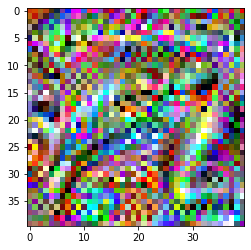

In [20]:
patch_img = Image.fromarray((adv_robust_patch).astype(np.uint8))
patch_img.save("RobustDPatch.png")
plt.imshow(patch_img)
plt.show()

Patching images

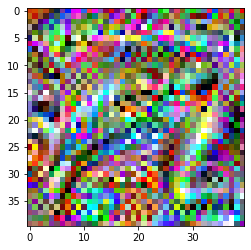

In [13]:
adv_robust_patch = Image.open("RobustDPatch.png").convert('RGB')
plt.imshow(adv_robust_patch)
plt.show()

In [14]:
robust_dpath_images = attackRobustDPatch.apply_patch(np.float32(images_array), patch_external=adv_robust_patch)

In [ ]:
draw_image_with_boxes(robust_dpath_images[0,:,:,:],art_model)

# Evaluating model performance after attacks

In [31]:
normal_predictions = art_model.predict(np.float32(images_array))
dpatch_predictions = art_model.predict(np.float32(dpath_images[0,:,:,:]))
robust_dpatch_predictions = art_model.predict(np.float32(robust_dpath_images[0,:,:,:]))

RuntimeError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 6.00 GiB total capacity; 3.87 GiB already allocated; 0 bytes free; 4.21 GiB reserved in total by PyTorch)

Converting predictions to MeanAveragePrecision format

In [3]:
def patched_to_MAP(preds):
    filter_normal = preds["scores"] > 0.1
    filter_scores = preds["scores"][filter_normal]
    stack = np.stack((preds["labels"], preds["scores"]), axis=1)
    gt = np.concatenate((preds["boxes"], stack), axis=1)
    gt = gt[filter_normal]
    return gt
    
def normal_to_MAP(preds):
    normal = patched_to_MAP(preds)
    normal = normal[:,0:5]
    N = normal.shape[0]
    normal = np.concatenate((normal, np.zeros((N,2))), axis = 1)
    return normal

In [ ]:
normalmAP = normal_to_MAP(normal_predictions)
dpatchmAP = patched_to_MAP(dpatch_predictions)
robust_dpatchmAP = patched_to_MAP(robust_dpatch_predictions)

DPatch mAP:

In [9]:
# create metric_fn
metric_fn = MeanAveragePrecision(num_classes=len(list(set(COCO_INSTANCE_CATEGORY_NAMES)))-1)

metric_fn.add(dpatchmAP, normalmAP)

# compute PASCAL VOC metric
print(f"VOC PASCAL mAP: {metric_fn.value(iou_thresholds=0.5, recall_thresholds=np.arange(0., 1.1, 0.1))['mAP']}")

# compute PASCAL VOC metric at the all points
print(f"VOC PASCAL mAP in all points: {metric_fn.value(iou_thresholds=0.5)['mAP']}")

# compute metric COCO metric
print(f"COCO mAP: {metric_fn.value(iou_thresholds=np.arange(0.5, 1.0, 0.05), recall_thresholds=np.arange(0., 1.01, 0.01), mpolicy='soft')['mAP']}")

VOC PASCAL mAP: 0.5
VOC PASCAL mAP in all points: 0.5
COCO mAP: 0.5


Robust DPatch

In [ ]:
# create metric_fn
metric_fn = MeanAveragePrecision(num_classes=len(list(set(COCO_INSTANCE_CATEGORY_NAMES)))-1)

metric_fn.add(robust_dpatchmAP, normalmAP)

# compute PASCAL VOC metric
print(f"VOC PASCAL mAP: {metric_fn.value(iou_thresholds=0.5, recall_thresholds=np.arange(0., 1.1, 0.1))['mAP']}")

# compute PASCAL VOC metric at the all points
print(f"VOC PASCAL mAP in all points: {metric_fn.value(iou_thresholds=0.5)['mAP']}")

# compute metric COCO metric
print(f"COCO mAP: {metric_fn.value(iou_thresholds=np.arange(0.5, 1.0, 0.05), recall_thresholds=np.arange(0., 1.01, 0.01), mpolicy='soft')['mAP']}")

# Defences

In [40]:
defence_gausian = art.defences.preprocessor.GaussianAugmentation()
defence = art.defences.preprocessor.FeatureSqueezing(clip_values=[0,255])

In [41]:
art_model_defence = art.estimators.object_detection.PyTorchFasterRCNN(clip_values=[0,255],preprocessing_defences= [defence] )

[{'boxes': array([[  4.7716265,   5.129993 ,  37.259216 ,  34.707985 ],
       [  3.7795727,   1.5974112,  36.45576  ,  21.886747 ],
       [119.250404 , 101.05175  , 176.53825  , 157.22073  ],
       [ 37.288177 , 104.14278  ,  74.39384  , 161.73454  ],
       [  2.1932316,   8.1468315,  40.093655 ,  87.57862  ],
       [  0.3918231,   0.       ,  51.384266 , 113.16666  ]],
      dtype=float32), 'labels': array([77, 77, 24, 24, 77,  6], dtype=int64), 'scores': array([0.99999833, 0.9997471 , 0.9987601 , 0.9980652 , 0.30340135,
       0.05478857], dtype=float32)}]


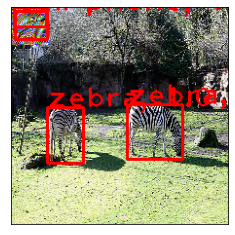

In [43]:
torch.cuda.empty_cache()
image = pathed_image[1,:,:,:].astype(int)
image = np.expand_dims(image, 0)
draw_image_with_boxes(image,art_model_defence )

# Evaluating model performance with defences

In [18]:
# TODO
#similar to evaluating attact